<a href="https://colab.research.google.com/github/ilkzeyden/call-center-customer-conversationsclustering-and-classification/blob/main/ak%C4%B1%C5%9F_i%C3%A7in_model_e%C4%9Fitimi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install datasets
!pip uninstall torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade transformers datasets
!pip cache purge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-o

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer



# 1. Excel'den verileri yükle
file_path = r'/content/drive/My Drive/akış-diyagramı-örnekleri-verileri.xlsx'
veriler = pd.read_excel(file_path)

# Giriş ve çıkış verilerini ayıkla
veriler['input_text'] = veriler['Akış Cümlesi']  # Giriş verisi
veriler['output_text'] = veriler.apply(
    lambda row: f"{row['Adım No']} {row['Adım Açıklaması']} {row['Adım Türü']} {row['Koşul (Varsa)']} {row['Evet Durumu (Sonraki Adım)']} {row['Hayır Durumu (Sonraki Adım)']}", axis=1
)

#veriler = veriler.rename(columns={"Akış Cümlesi": "input_text", "Çıkış Verisi": "output_text"})
#veriler["output_text"] = veriler["output_text"].astype(str)  # Çıkışı metne dönüştür

veriler["Evet Durumu (Sonraki Adım)"] = veriler["Evet Durumu (Sonraki Adım)"].apply(lambda x: None if isinstance(x, str) and x.strip() == '-' else x)
veriler["Hayır Durumu (Sonraki Adım)"] = veriler["Evet Durumu (Sonraki Adım)"].apply(lambda x: None if isinstance(x, str) and x.strip() == '-' else x)

# Veri önizleme
print("Veri önizleme:", veriler.head())

# 2. Dataset formatına dönüştür
dataset = Dataset.from_pandas(veriler)

# 3. Model ve Tokenizer yükle
model_name = "t5-small"  # Küçük bir model kullanıyoruz
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


#tokenized_datasets = dataset.map(preprocess_function, batched=True)
# 4. Tokenizasyon işlemi
def preprocess_function(examples):
    inputs = [str(x) for x in examples["input_text"]]  # Giriş cümleleri
    targets = [str(x) for x in examples["output_text"]]  # Çıkış detayları
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=512, truncation=True, padding='max_length').input_ids   # Çıkışlar daha uzun olabilir
    model_inputs["labels"] = labels
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

# 5. Eğitim ayarları
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    save_steps=500,
    logging_dir="./logs"
)

from sklearn.model_selection import train_test_split

# Eğitim ve doğrulama verilerini ayırma

train_dataset = tokenized_datasets.train_test_split(test_size=0.1, seed=42)["train"]
eval_dataset = tokenized_datasets.train_test_split(test_size=0.1, seed=42)["test"]

# 6. GPU kontrolü ve modele aktarım
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Modeli GPU'ya taşı

# 6. Eğitici (Trainer) tanımlama
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Doğrulama veri kümesini ekleyin
    tokenizer=tokenizer
)

# 6. Eğitici (Trainer) tanımlama
#trainer = Trainer(
 #   model=model,
 #   args=training_args,
 #   train_dataset=tokenized_datasets,
 #   tokenizer=tokenizer
#)

# 7. Modeli eğit
trainer.train()

# 8. Tahmin testi
def predict(cumle):
    inputs = tokenizer(cumle, return_tensors="pt", max_length=128, truncation=True)
    outputs = model.generate(**inputs, max_length=512)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test için örnek bir cümle
test_cumle = "Sipariş bilgilerini al, stokta ürün var mı kontrol et, varsa siparişi kaydet."
tahmin = predict(test_cumle)
print("Tahmin edilen adımlar ve türleri:", tahmin)


Veri önizleme:    Akış ID                                       Akış Cümlesi  Adım No  \
0        1  "Sipariş bilgilerini al, stokta ürün var mı ko...        1   
1        1  "Sipariş bilgilerini al, stokta ürün var mı ko...        2   
2        1  "Sipariş bilgilerini al, stokta ürün var mı ko...        3   
3        1  "Sipariş bilgilerini al, stokta ürün var mı ko...        4   
4        1  "Sipariş bilgilerini al, stokta ürün var mı ko...        5   

  Adım Türü                Adım Açıklaması Koşul (Varsa)  \
0     Süreç                Sistemi başlat.             -   
1     Süreç        Sipariş bilgilerini al.             -   
2     Koşul            Stokta ürün var mı?       Var mı?   
3     Süreç    Siparişi oluştur ve kaydet.             -   
4     Süreç  "Stokta yok" mesajını göster.             -   

   Evet Durumu (Sonraki Adım)  Hayır Durumu (Sonraki Adım)  \
0                         2.0                          2.0   
1                         3.0                          

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/237 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-71f26dbcb0c9>:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ilkay-deniz (joseph-agyeman-sakarya-niversitesi). Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,4.021179
2,No log,0.695338
3,No log,0.421871


Tahmin edilen adımlar ve türleri: 


In [ ]:
#Kayıpları izlemek için
# Eğitim ve doğrulama kaybını kontrol et
logs = trainer.state.log_history  # Eğitim loglarını al
train_loss = [log['loss'] for log in logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]

print("Eğitim Kayıpları (Train Loss):", train_loss)
print("Doğrulama Kayıpları (Eval Loss):", eval_loss)


Eğitim Kayıpları (Train Loss): []
Doğrulama Kayıpları (Eval Loss): [4.021178722381592, 0.6953378319740295, 0.421870619058609]


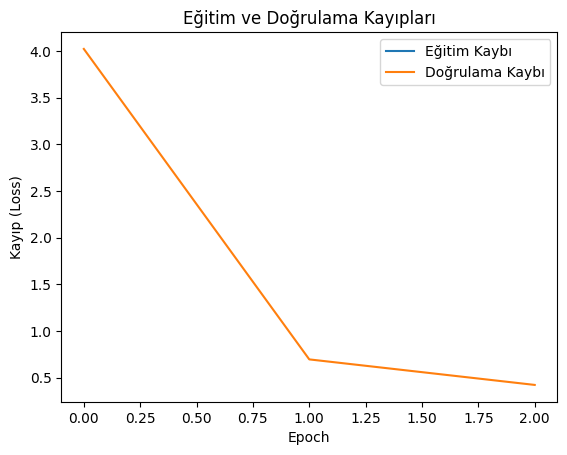

In [ ]:
#Görsel analiz için
import matplotlib.pyplot as plt

# Kayıpları çiz
plt.plot(train_loss, label="Eğitim Kaybı")
plt.plot(eval_loss, label="Doğrulama Kaybı")
plt.xlabel("Epoch")
plt.ylabel("Kayıp (Loss)")
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.legend()
plt.show()
